In [231]:
# Import statements
import docplex
from docplex.mp.model import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Defining the model class

In [396]:
class PSH(Model):
    reservoirs = np.arange(2)
    upstream_reservoirs = {
        0: [],
        1: [0]
    }
    hydro_units = np.arange(2)
    hu_affiliation = {
        0: [0,1],
        1: []
    }
    pumped_storage_units = np.arange(1)
    ps_affiliation = {
        0: [0],
        1: []
    }

    periods = np.arange(10)
    subregions = np.arange(16)
    vertices = np.arange(3)

    # Parameters
    initial_volume = 100000
    hu_initial_state = {j:1 for j in hydro_units}
    projected_prices = [10, 20, 15, 15, 15, 10, 10, 10, 5, 25]
    period_length = 1
    natural_inflow = pd.DataFrame(data=2, index=reservoirs, columns=periods)
    travel_times = pd.DataFrame(data=[[0,1],[0,0]], index=reservoirs, columns=reservoirs)
    spillage = pd.DataFrame(data=1, index=reservoirs, columns=periods)

    # Volume limits
    volume_limits = pd.DataFrame(index=['max', 'min'], columns=reservoirs)
    volume_limits.loc['max':,] = 2000000
    volume_limits.loc['min':,] = 10000

    # ------ To be replaced ------
    ps_power_generation_limits = pd.DataFrame(index=['max', 'min'], columns=pumped_storage_units)
    ps_power_generation_limits.loc['max':,] = 8
    ps_power_generation_limits.loc['min':,] = 2

    # Pumped-storage unit limits
    ps_power_pumping_limits = pd.DataFrame(index=['max', 'min'], columns=pumped_storage_units)
    ps_power_pumping_limits.loc['max':,] = 4
    ps_power_pumping_limits.loc['min':,] = 1

    ps_discharge_pumping_limits = pd.DataFrame(index=['max', 'min'], columns=pumped_storage_units)
    ps_discharge_pumping_limits.loc['max':,] = 10
    ps_discharge_pumping_limits.loc['min':,] = 1

    # Linearization
    hu_head_limits = pd.DataFrame(index=['max', 'min'], columns=hydro_units)
    hu_head_limits.loc['max':,] = 10
    hu_head_limits.loc['min':,] = 4

    hu_discharge_limits = pd.DataFrame(index=['max', 'min'], columns=hydro_units)
    hu_discharge_limits.loc['max':,] = 20
    hu_discharge_limits.loc['min':,] = 10

    ps_head_limits = pd.DataFrame(index=['max', 'min'], columns=pumped_storage_units)
    ps_head_limits.loc['max':,] = 10
    ps_head_limits.loc['min':,] = 4

    ps_discharge_generation_limits = pd.DataFrame(index=['max', 'min'], columns=pumped_storage_units)
    ps_discharge_generation_limits.loc['max':,] = 15
    ps_discharge_generation_limits.loc['min':,] = 10

    # Defining the rho-values to calculate the power production
    rho_values = pd.DataFrame(index=np.arange(6), columns=hydro_units)
    rho_values.loc[0:,] = 0.85
    rho_values.loc[1:,] = 0.02
    rho_values.loc[2:,] = 0.03
    rho_values.loc[3:,] = -0.0001
    rho_values.loc[4:,] = -0.0002
    rho_values.loc[5:,] = -0.00001
    
    hu_h_vertices = []
    hu_q_vertices = []
    hu_p_vertices = []

    ps_h_vertices = []
    ps_q_vertices = []
    ps_p_vertices = []
    

    def __init__(self):
        super().__init__()

    
    # Method to calculate the head vertices for the linearization
    def head_vertices(self, units: list, affiliation: dict, limits: pd.DataFrame) -> list:

        #Defining a 4-Dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])
        
        for i in self.reservoirs:
            for j in affiliation[i]:

                # Dividing the water head into equally large intervals, that fill the domain
                head_interval = (limits.loc['max',j] - limits.loc['min',j]) / (len(self.subregions) / 2)
                for l in self.subregions:
                    if l % 2 == 0: # Defining the coordonates of 2 trangles in 1 itteration

                        # First triangle
                        vertice_values[i,j,l,0] = limits.loc['min',j] + l / 2 * head_interval # bottom left
                        vertice_values[i,j,l,1] = limits.loc['min',j] + l / 2 * head_interval + head_interval # bottom right
                        vertice_values[i,j,l,2] = vertice_values[i,j,l,0] # top left

                        # Secon triangle
                        vertice_values[i,j,l+1,0] = vertice_values[i,j,l,0] # top left
                        vertice_values[i,j,l+1,1] = vertice_values[i,j,l,1]# top right
                        vertice_values[i,j,l+1,2] = vertice_values[i,j,l,1] # bottom right

        return vertice_values
    

    # Method to calculate the discharge vertrices for the linearization
    def discharge_vertices(self, units: list, affiliation: dict, limits: pd.DataFrame) -> list:

        #Defining a 4-Dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])

        for i in self.reservoirs:
            for j in affiliation[i]:
                for l in self.subregions:
                    if l % 2 == 0: # Defining the coordonates of 2 trangles in 1 itteration
                        vertice_values[i,j,l,0] = limits.loc['min',j] # bottom left
                        vertice_values[i,j,l,1] = limits.loc['min',j] # bottom right
                        vertice_values[i,j,l,2] = limits.loc['max',j] # top left

                        vertice_values[i,j,l+1,0] = limits.loc['max',j] # top left
                        vertice_values[i,j,l+1,1] = limits.loc['max',j] # top right
                        vertice_values[i,j,l+1,2] = limits.loc['min',j] # bottom right
        
        return vertice_values
    

    # Method to calculate the power vertices for the linearization
    def power_vertices(self, units: list, affiliation: dict, h_vertices: list, q_vertices: list) -> list:

        #Defining a 4-Dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])
        
        for i in self.reservoirs:
            for j in affiliation[i]:
                for l in self.subregions:
                    for r in self.vertices:

                        # Applying the formulas from the base paper
                        efficiency = self.rho_values.loc[0,j] + self.rho_values.loc[1,j] * h_vertices[i,j,l,r] + self.rho_values.loc[2,j] * q_vertices[i,j,l,r] + self.rho_values.loc[3,j] * (h_vertices[i,j,l,r] ** 2) + self.rho_values.loc[4,j] * (q_vertices[i,j,l,r] ** 2) + self.rho_values.loc[5,j] * h_vertices[i,j,l,r] * q_vertices[i,j,l,r]
                        vertice_values[i,j,l,r] = 981 * (10 ** -3) * efficiency * h_vertices[i,j,l,r] * q_vertices[i,j,l,r]

        return vertice_values
    

    # Method to define the decision variabels
    def define_decision_variables(self):
        self.clear()
        self.volume = self.continuous_var_matrix(self.reservoirs, self.periods, name='reservoir_volume')
        self.total_discharge = self.continuous_var_matrix(self.reservoirs, self.periods, name='total_discharge_ex_ps')
        self.hu_discharge = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='discharge_hydro_units')
        self.hu_head = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='head_hydro_units')
        self.hu_power = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='power_output_hydro_units')
        self.active_subregion = self.binary_var_dict([(i, j, t, l) for i in self.reservoirs for j in self.hydro_units for t in self.periods for l in self.subregions], name='active_subregions')
        self.alpha_coefficient = self.continuous_var_dict([(i, j, t, l, r) for i in self.reservoirs for j in self.hydro_units for t in self.periods for l in self.subregions for r in self.vertices], name='convex_combination_coefficients')
        self.hu_start_up = self.binary_var_cube(self.reservoirs, self.hydro_units, self.periods, name='start_ups_hydro_units')
        self.hu_shut_down = self.binary_var_cube(self.reservoirs, self.hydro_units, self.periods, name='shut_downs_hydro_units')
        self.hu_state = self.binary_var_cube(self.reservoirs, self.hydro_units, self.periods, name='state_hydro_units')
        self.ps_power_gen = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='power_output_pumped_storage_units')
        self.ps_power_pump = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='power_consumption_pumped_storage_units')
        self.ps_discharge_gen = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='discharge_pumped_storage_units')
        self.ps_discharge_pump = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='pumped_upstream_pumped_storage_units')
        self.ps_state_gen = self.binary_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='generation_state_pumped_storage_units')
        self.ps_state_pump = self.binary_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='pumping_state_pumped_storage_units')


    # Method that defines the constraints of the model
    def define_contraints(self):
        self.clear_constraints()
        
        # (2) Water-balance constraint
        for i in self.reservoirs[1:]:
            for t in self.periods[1:]:
                self.add_constraint(self.volume[i,t] == self.volume[i,t-1] + 3600 * self.period_length * (self.natural_inflow.loc[i,t] - self.total_discharge[i,t] + self.sum(self.total_discharge[m,t-self.travel_times.loc[m,i]] for m in self.upstream_reservoirs[i]) - self.sum(self.ps_discharge_pump[i,k,t] for k in self.ps_affiliation[i-1]) + self.sum(self.ps_discharge_pump[i,k,t] for k in self.ps_affiliation[i])))
        for i in self.reservoirs[1:]:
            self.add_constraint(self.volume[i,0] == self.initial_volume + 3600 * self.period_length * (self.natural_inflow.loc[i,0] - self.total_discharge[i,0] + 0 - self.sum(self.ps_discharge_pump[i,k,0] for k in self.ps_affiliation[i-1]) + self.sum(self.ps_discharge_pump[i,k,0] for k in self.ps_affiliation[i]))) # There can't be inflows from upstream reservoirs in the first period
        for t in self.periods[1:]:
            self.add_constraint(self.volume[0,t] == self.volume[0,t-1] + 3600 * self.period_length * (self.natural_inflow.loc[0,t] - self.total_discharge[0,t] + 0 - 0 + self.sum(self.ps_discharge_pump[0,k,t] for k in self.ps_affiliation[0]))) # No inflow from upstream reservoirs and no pumped water to upstream reservoirs for the first reservoir
        self.add_constraint(self.volume[0,0] == self.initial_volume + 3600 * self.period_length * (self.natural_inflow.loc[0,0] - self.total_discharge[0,0] + 0 - 0 + self.sum(self.ps_discharge_pump[0,k,0] for k in self.ps_affiliation[0]))) # No inflow from upstream reservoirs and no pumped water to upstream reservoirs for the first reservoir

        # (3) Total discharge
        for i in self.reservoirs:
            for t in self.periods:
                self.add_constraint(self.total_discharge[i,t] == self.spillage.loc[i,t] + self.sum(self.hu_discharge[i,j,t] for j in self.hu_affiliation[i]) + self.sum(self.ps_discharge_gen[i,k,t] for k in self.ps_affiliation[i]))

        # (4) Water-level limits
        for i in self.reservoirs:
            for t in self.periods:
                self.add_constraint(self.volume[i,t] >= self.volume_limits.loc['min',i])
                self.add_constraint(self.volume[i,t] <= self.volume_limits.loc['max',i])

        # (8) Subregion can only be active, if hydro unit is in
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.sum(self.active_subregion[i,j,t,l] for l in self.subregions) == self.hu_state[i,j,t])

        # (9) Convex combination coefficients must sum up to 1 or 0
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        self.add_constraint(self.sum(self.alpha_coefficient[i,j,t,l,r] for r in self.vertices) == self.active_subregion[i,j,t,l])

        # (10) Non-negativity condition for convex combination coefficients
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        for r in self.vertices:
                            self.add_constraint(self.alpha_coefficient[i,j,t,l,r] >= 0)

        # (11)-(13) Calculation of linearized water head, discharge, and power output
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.hu_head[i,j,t] == self.sum(self.sum(self.alpha_coefficient[i,j,t,l,r] * self.hu_h_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (11) water head
                    self.add_constraint(self.hu_discharge[i,j,t] == self.sum(self.sum(self.alpha_coefficient[i,j,t,l,r] * self.hu_q_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (12) discharge
                    self.add_constraint(self.hu_power[i,j,t] == self.sum(self.sum(self.alpha_coefficient[i,j,t,l,r] * self.hu_p_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (13) power

        # (14)-(15) State, start up, and shut down relation
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods[1:]:
                    self.add_constraint(self.hu_state[i,j,t] - self.hu_state[i,j,t-1] == self.hu_start_up[i,j,t-1] - self.hu_shut_down[i,j,t-1])

        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                self.add_constraint(self.hu_state[i,j,0] == self.hu_initial_state[j]) # In the first period an initial state is set

        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.hu_start_up[i,j,t] + self.hu_shut_down[i,j,t] <= 1)

        # (16)-(22) Pumped storage unit constraints
        for i in self.reservoirs:
            for k in self.pumped_storage_units:
                for t in self.periods:

                    # (16)-(17) power generation and water discharge
                    #self.add_constraint(self.ps_power[i,k,t] == self.ps_power_gen[i,k,t] - self.ps_power_pump[i,k,t])
                    #self.add_constraint(self.ps_discharge[i,k,t] == self.ps_discharge_gen[i,k,t] - self.ps_discharge_pump[i,k,t])

                    # (18) state constraint
                    self.add_constraint(self.ps_state_gen[i,k,t] + self.ps_state_pump[i,k,t] <= 1)

                    # (19)-(22) power and discharge limitations
                    self.add_constraint(self.ps_power_generation_limits.loc['min',k] * self.ps_state_gen[i,k,t] <= self.ps_power_gen[i,k,t])
                    self.add_constraint(self.ps_power_generation_limits.loc['max',k] * self.ps_state_gen[i,k,t] >= self.ps_power_gen[i,k,t])

                    self.add_constraint(self.ps_discharge_generation_limits.loc['min',k] * self.ps_state_gen[i,k,t] <= self.ps_discharge_gen[i,k,t])
                    self.add_constraint(self.ps_discharge_generation_limits.loc['max',k] * self.ps_state_gen[i,k,t] >= self.ps_discharge_gen[i,k,t])

                    self.add_constraint(self.ps_power_pumping_limits.loc['min',k] * self.ps_state_pump[i,k,t] <= self.ps_power_pump[i,k,t])
                    self.add_constraint(self.ps_power_pumping_limits.loc['max',k] * self.ps_state_pump[i,k,t] >= self.ps_power_pump[i,k,t])

                    self.add_constraint(self.ps_discharge_pumping_limits.loc['min',k] * self.ps_state_pump[i,k,t] <= self.ps_discharge_pump[i,k,t])
                    self.add_constraint(self.ps_discharge_pumping_limits.loc['max',k] * self.ps_state_pump[i,k,t] >= self.ps_discharge_pump[i,k,t])
        

    # Method to define the objective value and to solve the model
    def solve_model(self):
        J = self.sum(self.sum(self.projected_prices[t] * self.period_length * (self.sum(self.hu_power[i,j,t] for j in self.hu_affiliation[i]) + self.sum(self.ps_power_gen[i,k,t] for k in self.ps_affiliation[i]) - self.sum(self.ps_power_pump[i,k,t] for k in self.ps_affiliation[i])) for i in self.reservoirs) for t in self.periods)
        self.maximize(J)
        self.solve()
        

#### Validation the correct calculation of the vertices for the linearization

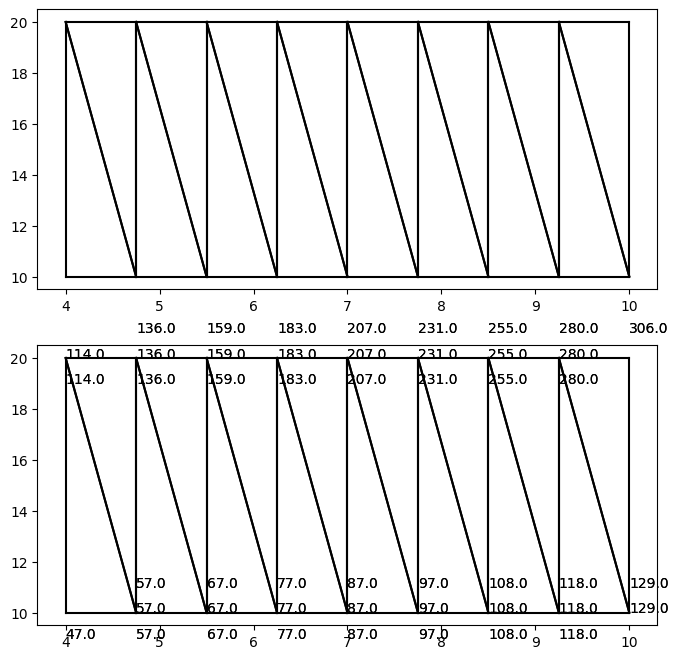

In [369]:
fig, ax = plt.subplots(nrows=len(psh.hydro_units), ncols=1, figsize=(8,8))
for j in psh.hydro_units:
    for l in psh.subregions:
        ax[j].plot([psh.hu_h_vertices[0,j,l,0], psh.hu_h_vertices[0,j,l,1]], [psh.hu_q_vertices[0,j,l,0], psh.hu_q_vertices[0,j,l,1]], color='black')
        ax[j].plot([psh.hu_h_vertices[0,j,l,1], psh.hu_h_vertices[0,j,l,2]], [psh.hu_q_vertices[0,j,l,1], psh.hu_q_vertices[0,j,l,2]], color='black')
        ax[j].plot([psh.hu_h_vertices[0,j,l,2], psh.hu_h_vertices[0,j,l,0]], [psh.hu_q_vertices[0,j,l,2], psh.hu_q_vertices[0,j,l,0]], color='black')

        plt.annotate(round(psh.hu_p_vertices[0,j,l,0],0), xy=(psh.hu_h_vertices[0,j,l,0], psh.hu_q_vertices[0,j,l,0]), xytext=(psh.hu_h_vertices[0,j,l,0], psh.hu_q_vertices[0,j,l,0]-1))
        plt.annotate(round(psh.hu_p_vertices[0,j,l,1],0), xy=(psh.hu_h_vertices[0,j,l,1], psh.hu_q_vertices[0,j,l,1]), xytext=(psh.hu_h_vertices[0,j,l,1], psh.hu_q_vertices[0,j,l,1]+1))
        plt.annotate(round(psh.hu_p_vertices[0,j,l,2],0), xy=(psh.hu_h_vertices[0,j,l,2], psh.hu_q_vertices[0,j,l,2]), xytext=(psh.hu_h_vertices[0,j,l,2], psh.hu_q_vertices[0,j,l,2]))

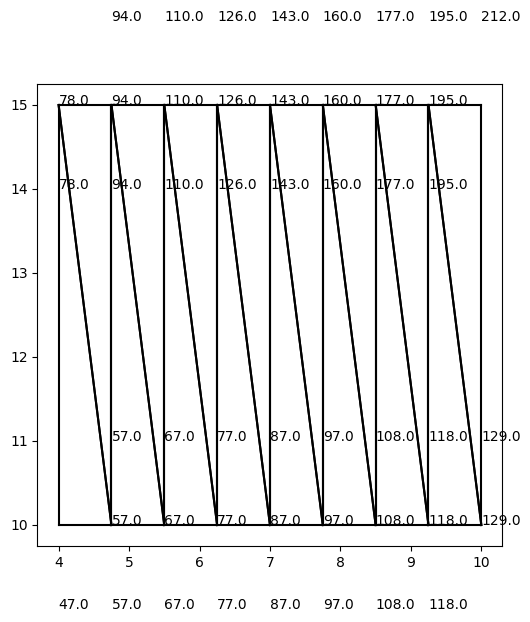

In [398]:
fig, ax = plt.subplots(figsize=(6,6))
for j in psh.pumped_storage_units:
    for l in psh.subregions:
        ax.plot([psh.ps_h_vertices[0,j,l,0], psh.ps_h_vertices[0,j,l,1]], [psh.ps_q_vertices[0,j,l,0], psh.ps_q_vertices[0,j,l,1]], color='black')
        ax.plot([psh.ps_h_vertices[0,j,l,1], psh.ps_h_vertices[0,j,l,2]], [psh.ps_q_vertices[0,j,l,1], psh.ps_q_vertices[0,j,l,2]], color='black')
        ax.plot([psh.ps_h_vertices[0,j,l,2], psh.ps_h_vertices[0,j,l,0]], [psh.ps_q_vertices[0,j,l,2], psh.ps_q_vertices[0,j,l,0]], color='black')

        plt.annotate(round(psh.ps_p_vertices[0,j,l,0],0), xy=(psh.ps_h_vertices[0,j,l,0], psh.ps_q_vertices[0,j,l,0]), xytext=(psh.ps_h_vertices[0,j,l,0], psh.ps_q_vertices[0,j,l,0]-1))
        plt.annotate(round(psh.ps_p_vertices[0,j,l,1],0), xy=(psh.ps_h_vertices[0,j,l,1], psh.ps_q_vertices[0,j,l,1]), xytext=(psh.ps_h_vertices[0,j,l,1], psh.ps_q_vertices[0,j,l,1]+1))
        plt.annotate(round(psh.ps_p_vertices[0,j,l,2],0), xy=(psh.ps_h_vertices[0,j,l,2], psh.ps_q_vertices[0,j,l,2]), xytext=(psh.ps_h_vertices[0,j,l,2], psh.ps_q_vertices[0,j,l,2]))

## Solving the model

In [397]:
# Creating a model instance
psh = PSH()
psh.hu_h_vertices = psh.head_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_head_limits)
psh.hu_q_vertices = psh.discharge_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_discharge_limits)
psh.hu_p_vertices = psh.power_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_h_vertices, psh.hu_q_vertices)

psh.ps_h_vertices = psh.head_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_head_limits)
psh.ps_q_vertices = psh.discharge_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_discharge_generation_limits)
psh.ps_p_vertices = psh.power_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_h_vertices, psh.ps_q_vertices)

psh.define_decision_variables()
psh.define_contraints()
psh.solve_model()
psh.solve_details

docplex.mp.SolveDetails(time=0.058625,status='integer optimal solution')

## Plotting the Data

In [376]:
v = pd.DataFrame(index=psh.reservoirs, columns=psh.periods)
for i in psh.reservoirs:
    for t in psh.periods:
        v.loc[i,t] = psh.volume[i,t].solution_value

v

,0,1,2,3,4,5,6,7,8,9
0,67600.0,35200.0,74800.0,42400.0,10000.0,49600.0,89200.0,74800.0,114400.0,10000.0
1,67600.0,110800.0,154000.0,125200.0,200800.0,280000.0,287200.0,294400.0,355600.0,362800.0


In [377]:
d = pd.DataFrame(index=psh.reservoirs, columns=psh.periods)
for i in psh.reservoirs:
    for t in psh.periods:
        d.loc[i,t] = psh.total_discharge[i,t].solution_value

d

,0,1,2,3,4,5,6,7,8,9
0,21.0,21.0,1.0,21.0,21.0,1.0,1.0,16.0,1.0,41.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [378]:
psh.spillage

,0,1,2,3,4,5,6,7,8,9
0,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1


In [379]:
hu = pd.DataFrame(index=psh.reservoirs, columns=psh.periods)
for i in psh.reservoirs:
    for t in psh.periods:
        hu.loc[i,t] = psh.hu_discharge[i,0,t].solution_value

hu

,0,1,2,3,4,5,6,7,8,9
0,10.0,20.0,0,-0.0,20.0,0,0,15.0,0.0,20.0
1,0,0,0,0,0,0,0,0,0,0


In [380]:
hu = pd.DataFrame(index=psh.reservoirs, columns=psh.periods)
for i in psh.reservoirs:
    for t in psh.periods:
        hu.loc[i,t] = psh.hu_discharge[i,1,t].solution_value

hu

,0,1,2,3,4,5,6,7,8,9
0,10.0,0,0,20.0,0,0,0,0,0,20.0
1,0,0,0,0,0,0,0,0,0,0


In [381]:
ps = pd.DataFrame(index=psh.reservoirs, columns=psh.periods)
for i in psh.reservoirs:
    for t in psh.periods:
        ps.loc[i,t] = psh.ps_discharge_gen[i,0,t].solution_value

ps

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0


In [382]:
hu = pd.DataFrame(index=psh.hydro_units, columns=psh.periods)
for i in psh.reservoirs:
    for j in psh.hu_affiliation[i]:
        for t in psh.periods:
            hu.loc[j,t] = psh.hu_head[i,j,t].solution_value

hu

,0,1,2,3,4,5,6,7,8,9
0,10.0,10.0,0,0,10.0,0,0,10.0,0,10.0
1,10.0,0,0,10.0,0,0,0,0,0,10.0


In [383]:
hu = pd.DataFrame(index=psh.hydro_units, columns=psh.periods)
for i in psh.reservoirs:
    for j in psh.hu_affiliation[i]:
        for t in psh.periods:
            hu.loc[j,t] = psh.hu_power[i,j,t].solution_value

hu

,0,1,2,3,4,5,6,7,8,9
0,129.3939,305.6796,0,0,305.6796,0,0,217.53675,0,305.6796
1,129.3939,0,0,305.6796,0,0,0,0,0,305.6796


In [384]:
hu = pd.DataFrame(index=psh.hydro_units, columns=psh.periods)
for i in psh.reservoirs:
    for j in psh.hu_affiliation[i]:
        for t in psh.periods:
            hu.loc[j,t] = psh.hu_state[i,j,t].solution_value

hu

,0,1,2,3,4,5,6,7,8,9
0,1.0,1.0,0,0,1.0,0,0,1.0,0,1.0
1,1.0,0,0,1.0,0,0,0,0,0,1.0


In [385]:
hu = pd.DataFrame(index=psh.hydro_units, columns=psh.periods)
for i in psh.reservoirs:
    for j in psh.hu_affiliation[i]:
        for t in psh.periods:
            hu.loc[j,t] = psh.hu_start_up[i,j,t].solution_value

hu

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,1.0,0,0,1.0,0,1.0,0
1,0,0,1.0,0,0,0,0,0,1.0,0


In [386]:
hu = pd.DataFrame(index=psh.hydro_units, columns=psh.periods)
for i in psh.reservoirs:
    for j in psh.hu_affiliation[i]:
        for t in psh.periods:
            hu.loc[j,t] = psh.hu_shut_down[i,j,t].solution_value

hu

,0,1,2,3,4,5,6,7,8,9
0,0,1.0,0,0,1.0,0,0,1.0,0,0
1,1.0,0,0,1.0,0,0,0,0,0,0


In [391]:
ps = pd.DataFrame(index=psh.pumped_storage_units, columns=psh.periods)
for i in psh.reservoirs:
    for j in psh.ps_affiliation[i]:
        for t in psh.periods:
            ps.loc[j,t] = psh.ps_discharge_pump[i,j,t].solution_value

ps

,0,1,2,3,4,5,6,7,8,9
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


In [388]:
ps = pd.DataFrame(index=psh.pumped_storage_units, columns=psh.periods)

for j in psh.pumped_storage_units:
    for t in psh.periods:
        ps.loc[j,t] = psh.ps_discharge_gen[1,j,t].solution_value

ps

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0


In [389]:
ps = pd.DataFrame(index=psh.pumped_storage_units, columns=psh.periods)

for j in psh.pumped_storage_units:
    for t in psh.periods:
        ps.loc[j,t] = psh.ps_power_gen[i,j,t].solution_value

ps

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0


In [390]:
ps = pd.DataFrame(index=psh.pumped_storage_units, columns=psh.periods)
for i in psh.reservoirs:
    for j in psh.pumped_storage_units:
        for t in psh.periods:
            hu.loc[j,t] = psh.ps_power_pump[i,j,t].solution_value

hu

,0,1,2,3,4,5,6,7,8,9
0,4.0,4.0,4.0,4.0,4.0,0,0,0,0,0
1,1.0,0,0,1.0,0,0,0,0,0,0
